In [5]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split,KFold,GridSearchCV,cross_val_score

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression as LR
from sklearn.preprocessing import SplineTransformer,PolynomialFeatures

from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

import xgboost as xgb

In [6]:
# NEED TO CHECK WHETHER IT MAKES SENSE TO JUST RUN INDIVIDUAL MODELS BY STATE OR EVEN CITY
# IS THE BOOST TO ACCURACY SIGNIFICANT? DOES THE POTENTIAL COST OF TRAINING OUTWEIGH BENEFITS?

In [7]:
aws_bucket=os.getenv('AWS_RE_BUCKET')
aws_key=os.getenv('AWS_RE_BUCKET_KEY')
aws_secret=os.getenv('AWS_RE_BUCKET_SECRET')

date="2023-06-01"
state="CA"
states=    states=['AL',
 'NE',
 'AK',
 'NV',
 'AZ',
 'NH',
 'AR',
 'NJ',
 'CA',
 'NM',
 'CO',
 'NY',
 'CT',
 'NC',
 'DE',
 'ND',
 'DC',
 'OH',
 'FL',
 'OK',
 'GA',
 'OR',
 'HI',
 'PA',
 'ID',
 'PR',
 'IL',
 'RI',
 'IN',
 'SC',
 'IA',
 'SD',
 'KS',
 'TN',
 'KY',
 'TX',
 'LA',
 'UT',
 'ME',
 'VT',
 'MD',
 'VA',
 'MA',
 'VI',
 'MI',
 'WA',
 'MN',
 'WV',
 'MS',
 'WI',
 'MO',
 'WY',
 'MT',
]

In [4]:
df_list=[]
for st in states:
    try:
        df = pd.read_parquet(path=aws_bucket+f"/{date}/{st}.parquet",storage_options={"key":aws_key,"secret":aws_secret})
        df_list.append(df)
    except:
        pass
    
df=pd.concat(df_list)
df=df.applymap(lambda x: np.nan if x=='nan' else x)

In [8]:
df.columns

Index(['SALE TYPE', 'TimeStamp', 'SOLD DATE', 'PROPERTY TYPE', 'ADDRESS',
       'CITY', 'STATE OR PROVINCE', 'ZIP OR POSTAL CODE', 'PRICE', 'BEDS',
       'BATHS', 'LOCATION', 'SQUARE FEET', 'LOT SIZE', 'YEAR BUILT',
       'DAYS ON MARKET', '$/SQUARE FEET', 'HOA/MONTH', 'STATUS',
       'NEXT OPEN HOUSE START TIME', 'NEXT OPEN HOUSE END TIME',
       'URL (SEE https://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)',
       'SOURCE', 'MLS#', 'FAVORITE', 'INTERESTED', 'LATITUDE', 'LONGITUDE'],
      dtype='object')

In [9]:
prop_types=['Single Family Residential', 'Mobile/Manufactured Home','Townhouse', 'Multi-Family (2-4 Unit)', 'Condo/Co-op','Multi-Family (5+ Unit)']

df_transformed=df[['CITY','STATE OR PROVINCE','PROPERTY TYPE','PRICE','BEDS','BATHS','SQUARE FEET','YEAR BUILT','DAYS ON MARKET','HOA/MONTH','LATITUDE','LONGITUDE']].dropna(axis=0).reset_index(drop=True).apply(lambda row: pd.to_numeric(row,errors='ignore'))

df_transformed=df_transformed[df_transformed['PROPERTY TYPE'].isin(prop_types)]

In [10]:
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197932 entries, 0 to 198454
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CITY               197932 non-null  object 
 1   STATE OR PROVINCE  197932 non-null  object 
 2   PROPERTY TYPE      197932 non-null  object 
 3   PRICE              197932 non-null  float64
 4   BEDS               197932 non-null  float64
 5   BATHS              197932 non-null  float64
 6   SQUARE FEET        197932 non-null  float64
 7   YEAR BUILT         197932 non-null  float64
 8   DAYS ON MARKET     197932 non-null  float64
 9   HOA/MONTH          197932 non-null  float64
 10  LATITUDE           197932 non-null  float64
 11  LONGITUDE          197932 non-null  float64
dtypes: float64(9), object(3)
memory usage: 19.6+ MB


In [122]:
df_transformed['PROPERTY TYPE'].unique()

array(['Single Family Residential', 'Multi-Family (2-4 Unit)',
       'Townhouse', 'Condo/Co-op', 'Mobile/Manufactured Home',
       'Multi-Family (5+ Unit)'], dtype=object)

In [123]:
temp=pd.get_dummies(data=df_transformed['PROPERTY TYPE'])

In [124]:
df_final=pd.concat([df_transformed,temp],axis=1)

In [125]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

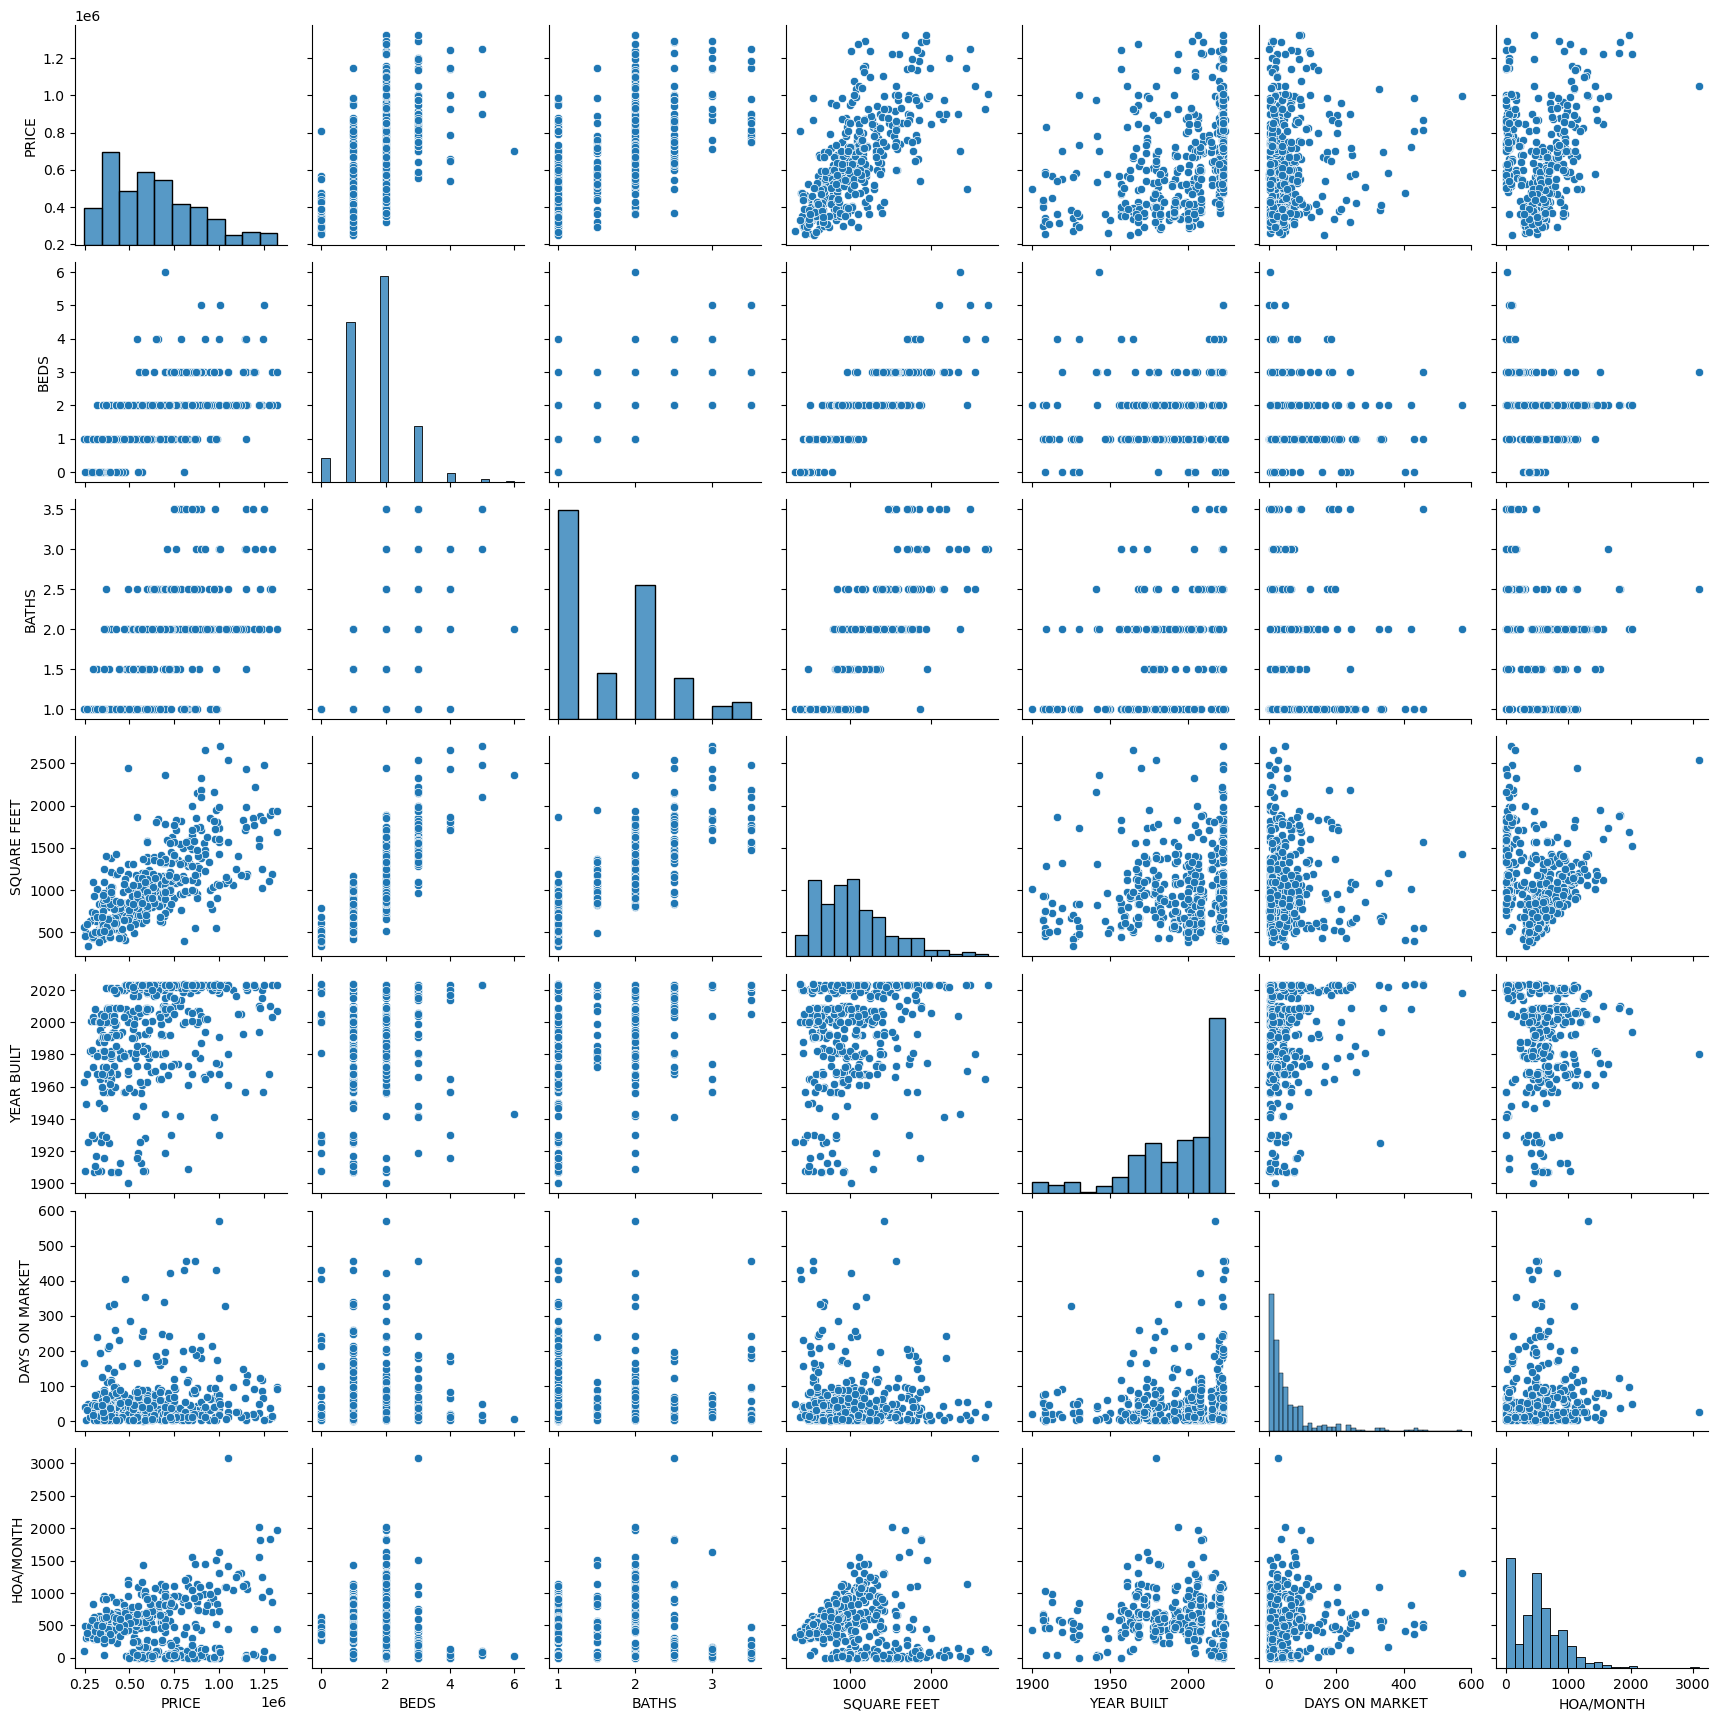

In [126]:
df_visual=df_transformed.drop(['LONGITUDE','LATITUDE'],axis=1)

df_visual=df_visual[~is_outlier(df_visual.drop(['CITY','STATE OR PROVINCE','PROPERTY TYPE'],axis=1).to_numpy())]

sns.pairplot(df_visual[df_visual['CITY']=='Seattle'])



In [149]:
df_final[df_final['PROPERTY TYPE']=='Single Family Residential'].drop(['CITY','STATE OR PROVINCE','PROPERTY TYPE','PRICE','LATITUDE','LONGITUDE'],axis=1)


# NEED TO FIND WAY TO PENALIZE PREDICTION VALUE BY DAYS ON MARKET, HAS A POSITIVE COEF
# 

,BEDS,BATHS,SQUARE FEET,YEAR BUILT,DAYS ON MARKET,HOA/MONTH,Condo/Co-op,Mobile/Manufactured Home,Multi-Family (2-4 Unit),Multi-Family (5+ Unit),Single Family Residential,Townhouse
0,4.0,4.5,3721.0,2015.0,13.0,21.0,0,0,0,0,1,0
1,4.0,3.0,2286.0,2022.0,49.0,13.0,0,0,0,0,1,0
3,3.0,3.0,3276.0,2003.0,114.0,125.0,0,0,0,0,1,0
4,4.0,2.5,2255.0,2015.0,142.0,21.0,0,0,0,0,1,0
5,4.0,2.0,2047.0,2023.0,2.0,50.0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
190339,3.0,2.5,1544.0,1993.0,153.0,30.0,0,0,0,0,1,0
190342,4.0,2.0,1764.0,2019.0,153.0,38.0,0,0,0,0,1,0
190346,2.0,2.0,1648.0,1983.0,153.0,42.0,0,0,0,0,1,0
190350,1.0,1.0,384.0,1996.0,28.0,5.0,0,0,0,0,1,0


In [153]:
df_slice=df_final[(df_final['PROPERTY TYPE']=='Single Family Residential') & (df_final['CITY']=='Seattle')]

,CITY,STATE OR PROVINCE,PROPERTY TYPE,PRICE,BEDS,BATHS,SQUARE FEET,YEAR BUILT,DAYS ON MARKET,HOA/MONTH,LATITUDE,LONGITUDE,Condo/Co-op,Mobile/Manufactured Home,Multi-Family (2-4 Unit),Multi-Family (5+ Unit),Single Family Residential,Townhouse
180878,Seattle,WA,Single Family Residential,1850000.0,2.0,2.5,2190.0,2016.0,110.0,350.0,47.645829,-122.326632,0,0,0,0,1,0
180885,Seattle,WA,Single Family Residential,1995000.0,3.0,2.0,2180.0,1951.0,116.0,7.0,47.662754,-122.270104,0,0,0,0,1,0
180890,Seattle,WA,Single Family Residential,875000.0,2.0,2.0,905.0,2023.0,19.0,100.0,47.662493,-122.323203,0,0,0,0,1,0
180891,Seattle,WA,Single Family Residential,1690000.0,4.0,3.5,2500.0,1908.0,19.0,100.0,47.662493,-122.323203,0,0,0,0,1,0
180899,Seattle,WA,Single Family Residential,788000.0,4.0,2.5,1823.0,2014.0,3.0,98.0,47.516478,-122.346320,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181354,Seattle,WA,Single Family Residential,1600000.0,3.0,1.5,2000.0,1935.0,10.0,124.0,47.702914,-122.377885,0,0,0,0,1,0
181388,Seattle,WA,Single Family Residential,925000.0,4.0,3.0,2660.0,1965.0,12.0,140.0,47.490738,-122.227902,0,0,0,0,1,0
181391,Seattle,WA,Single Family Residential,2300000.0,3.0,3.0,4348.0,2017.0,2.0,27.0,47.668884,-122.411340,0,0,0,0,1,0
181393,Seattle,WA,Single Family Residential,2275000.0,3.0,2.5,3340.0,2014.0,4.0,100.0,47.648354,-122.406572,0,0,0,0,1,0


In [11]:
df_slice=df_final[(df_final['PROPERTY TYPE']=='Single Family Residential')]

X_train,X_test,y_train,y_test=train_test_split(df_slice.drop(['CITY','STATE OR PROVINCE','PROPERTY TYPE','PRICE','LATITUDE','LONGITUDE'],axis=1).iloc[:,:5],df_slice['PRICE'],test_size=.25,random_state=100)

lr = LR()

lr.fit(X_train,y_train)

pred = lr.predict(X_test)

print("R2: ",r2_score(y_test,pred))
print("MAE: ",mean_absolute_error(y_test,pred))
print("MSE: ",mean_squared_error(y_test,pred))

NameError: name 'df_final' is not defined

In [157]:
lr.coef_

array([-9563.88216648, 16730.44495776,   491.98016863, -5812.68968602,
         718.26836383])

In [158]:
df_slice

,CITY,STATE OR PROVINCE,PROPERTY TYPE,PRICE,BEDS,BATHS,SQUARE FEET,YEAR BUILT,DAYS ON MARKET,HOA/MONTH,LATITUDE,LONGITUDE,Condo/Co-op,Mobile/Manufactured Home,Multi-Family (2-4 Unit),Multi-Family (5+ Unit),Single Family Residential,Townhouse
0,Bay Minette,AL,Single Family Residential,725000.0,4.0,4.5,3721.0,2015.0,13.0,21.0,30.747580,-87.883549,0,0,0,0,1,0
1,Bay Minette,AL,Single Family Residential,439900.0,4.0,3.0,2286.0,2022.0,49.0,13.0,30.905985,-87.773590,0,0,0,0,1,0
3,Bay Minette,AL,Single Family Residential,795000.0,3.0,3.0,3276.0,2003.0,114.0,125.0,30.842288,-87.908924,0,0,0,0,1,0
4,Bay Minette,AL,Single Family Residential,375000.0,4.0,2.5,2255.0,2015.0,142.0,21.0,30.748549,-87.882399,0,0,0,0,1,0
5,Spanish Fort,AL,Single Family Residential,342274.0,4.0,2.0,2047.0,2023.0,2.0,50.0,30.683200,-87.795707,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190339,Red Lodge,MT,Single Family Residential,699900.0,3.0,2.5,1544.0,1993.0,153.0,30.0,45.160537,-109.263286,0,0,0,0,1,0
190342,Red Lodge,MT,Single Family Residential,710000.0,4.0,2.0,1764.0,2019.0,153.0,38.0,45.188022,-109.265656,0,0,0,0,1,0
190346,Red Lodge,MT,Single Family Residential,529000.0,2.0,2.0,1648.0,1983.0,153.0,42.0,45.175239,-109.282272,0,0,0,0,1,0
190350,Roundup,MT,Single Family Residential,425000.0,1.0,1.0,384.0,1996.0,28.0,5.0,46.568379,-108.252269,0,0,0,0,1,0


In [159]:
pred

array([ 519661.64880508,  447116.29361607, 1261150.46397488, ...,
        324701.49325067, 1165038.83092971,  837393.13628441])

In [160]:
y_test

97807     536975.0
146403    309920.0
94182     865630.0
96263     295990.0
93315     585915.0
            ...   
180054    750000.0
115711    399900.0
5678      359850.0
140961    895000.0
159386    309500.0
Name: PRICE, Length: 29191, dtype: float64

In [161]:
X_test

,BEDS,BATHS,SQUARE FEET,YEAR BUILT,DAYS ON MARKET
97807,3.0,2.0,2124.0,2023.0,145.0
146403,4.0,3.0,2029.0,2022.0,91.0
94182,5.0,4.0,3548.0,2023.0,182.0
96263,4.0,2.0,1490.0,2023.0,19.0
93315,5.0,3.0,2934.0,2022.0,290.0
...,...,...,...,...,...
180054,4.0,2.5,3040.0,1992.0,11.0
115711,4.0,2.5,3400.0,1996.0,45.0
5678,3.0,2.0,1507.0,2021.0,280.0
140961,3.0,3.5,3065.0,2001.0,186.0


In [119]:
df_final.loc[235629]

CITY                                          Norridge
STATE OR PROVINCE                                   IL
PROPERTY TYPE                Single Family Residential
PRICE                                         799900.0
BEDS                                               4.0
BATHS                                              3.5
SQUARE FEET                                     4014.0
YEAR BUILT                                      2019.0
DAYS ON MARKET                                    28.0
LATITUDE                                     41.953496
LONGITUDE                                    -87.81868
Condo/Co-op                                          0
Mobile/Manufactured Home                             0
Multi-Family (2-4 Unit)                              0
Multi-Family (5+ Unit)                               0
Single Family Residential                            1
Townhouse                                            0
Name: 235629, dtype: object

In [162]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import SplineTransformer,PolynomialFeatures

from sklearn.model_selection import train_test_split,KFold,GridSearchCV,cross_val_score
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression as LR

from sklearn.neighbors import KNeighborsRegressor

import xgboost as xgb



In [ ]:
# PREPROCESSING PIPELINE

# 1 CONVERT CATEGORICAL PROEPRTY TYPE TO DUMMIES
# 2 FOR RADIAL VALUES (LAT, LON, INTERACTION) NEED TO SPLIT INTO GRADIENTS
# 3 INCORPORATE POLYNOMIAL INTERACTION AMONG SPLIT FEATURES

# Define the transformations for each column
preprocessor = ColumnTransformer(
    transformers=[
        ('periodic',SplineTransformer(include_bias=False), ['LATITUDE','LONGITUDE']),
        ('polynomial', PolynomialFeatures(degree=2, include_bias=False), ['LATITUDE', 'LONGITUDE'])
    ])

# Apply the transformations in a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
X_transformed = pipeline.fit_transform(df_final)


## END OF CURRENT PROGRESS FOR GRADIENT TRANSFORMATION INTO LINEAR MODEL

In [163]:
X_train,X_test,y_train,y_test=train_test_split(df_final.drop(['PROPERTY TYPE','CITY','STATE OR PROVINCE','PRICE'],axis=1),df_final['PRICE'],test_size=.25,random_state=101)


In [164]:
# Now try KNN to recommend comparables; may be best model you get if pricing model fails (clearly XGB ain't it)

### Start of XGBoost

In [165]:
# XGBoost not very successful; best R2_score at .63, but skyrockets MSE

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [166]:
dtrain.feature_names

['BEDS',
 'BATHS',
 'SQUARE FEET',
 'YEAR BUILT',
 'DAYS ON MARKET',
 'HOA/MONTH',
 'LATITUDE',
 'LONGITUDE',
 'Condo/Co-op',
 'Mobile/Manufactured Home',
 'Multi-Family (2-4 Unit)',
 'Multi-Family (5+ Unit)',
 'Single Family Residential',
 'Townhouse']

In [167]:
params = {
    'objective': 'reg:squarederror',  # Regression task with squared error loss
    'eval_metric': 'rmse'  # Evaluation metric: Root Mean Squared Error
}

In [168]:
num_rounds = 10  # Number of boosting rounds (iterations)
model = xgb.train(params, dtrain, num_rounds)

In [169]:
y_pred = model.predict(dtest)

In [170]:
y_pred

array([ 581947.9 , 1466473.5 ,  735871.1 , ...,  388180.  ,  467970.3 ,
        580419.44], dtype=float32)

In [172]:
print("R2: ",r2_score(y_test,y_pred))
print("MAE: ",mean_absolute_error(y_test,y_pred))
print("MSE: ",mean_squared_error(y_test,y_pred))

R2:  0.6003564958129752
MAE:  264457.0583785895
MSE:  1467809678671.4956


In [ ]:
grid.best_params_

# C: 700 ; D: 5
# C: 1000; D: 2

{'C': 700.0, 'degree': 5, 'kernel': 'poly'}